# Dataset Summary and Key Characteristics
# The dataset provides a comprehensive, structured foundation for analyzing electoral trends and political history in India:


1 Electoral Growth: The electors and votes columns clearly track the massive growth in the Indian electorate and voter participation over nearly six decades, with significant jumps in total votes polled visible between elections.

2 Turnout Stability: The Turnout column, though fluctuating, generally shows the evolution of voter participation, which can be analyzed for trends related to specific states, types of constituencies, or legislative reforms.

3 Party Dominance: Analysis of the party column, particularly when aggregated across seats won or total votes secured, reveals periods of single-party dominance (e.g., Indian National Congress in earlier years) and the subsequent rise of multi-party politics and regional consolidation up to the 2019 election.

4 Competitive Intensity: The margin and margin_percentage columns allow for measuring the competitiveness of each contest. Identifying constituencies with very low margins (≤1%) over the years provides insights into electoral volatility.

Geographical Nuance: By grouping on state, the dataset supports deep regional analysis, allowing users to find the top-performing party and compare average electoral margins across different states.



#  Initialize SparkSession

In [39]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Create a SparkSession
spark = (
    SparkSession.builder
    .appName("Loksabha_Elections_Analysis")
    .getOrCreate()
)
print("SparkSession created successfully.")

SparkSession created successfully.


# Load the Data

In [40]:
file_path = "Loksabha_1962-2019 .csv"
df = (
    spark.read.csv(
        path=file_path,
        header=True,
        inferSchema=True
    )
)
print("Data loaded successfully.")

Data loaded successfully.


# Initial Data Inspection

In [41]:
print("--- DataFrame Schema (Before Cleaning) ---")
df.printSchema()

print("\n--- First 5 Rows (Before Cleaning) ---")
df.show(5, truncate=False)

--- DataFrame Schema (Before Cleaning) ---
root
 |-- Pc_name: string (nullable = true)
 |-- no: string (nullable = true)
 |-- type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- candidate_name: string (nullable = true)
 |-- party: string (nullable = true)
 |-- electors: string (nullable = true)
 |-- votes: string (nullable = true)
 |-- Turnout: string (nullable = true)
 |-- margin: string (nullable = true)
 |-- margin%: string (nullable = true)
 |-- year: integer (nullable = true)


--- First 5 Rows (Before Cleaning) ---
+----------+---+----+---------------------------+--------------------------+--------------------------------+--------+--------+-------+------+-------+----+
|Pc_name   |no |type|state                      |candidate_name            |party                           |electors|votes   |Turnout|margin|margin%|year|
+----------+---+----+---------------------------+--------------------------+--------------------------------+--------+--------+-------+-----

#  Data Cleaning and Type Casting

In [42]:
comma_cols = ["electors", "votes", "margin"]

percent_cols = ["Turnout", "margin%"]

df_cleaned = df

for col_name in comma_cols:
    df_cleaned = df_cleaned.withColumn(
        col_name,
        F.regexp_replace(F.col(col_name), ",", "").cast("integer")
    )

for col_name in percent_cols:
    df_cleaned = df_cleaned.withColumn(
        col_name,
        F.regexp_replace(F.col(col_name), " %|%", "").cast("float")
    )

df_cleaned = df_cleaned.dropna(subset=['year']).withColumn('year', F.col('year').cast('integer'))

df_cleaned = df_cleaned.withColumnRenamed("margin%", "margin_percentage")

# --- Step 5: Verify Cleaned Data ---
print("\n--- Cleaned DataFrame Schema ---")
df_cleaned.printSchema()
print("\n--- First 5 Rows of Cleaned Data ---")
df_cleaned.show(5, truncate=False)


--- Cleaned DataFrame Schema ---
root
 |-- Pc_name: string (nullable = true)
 |-- no: string (nullable = true)
 |-- type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- candidate_name: string (nullable = true)
 |-- party: string (nullable = true)
 |-- electors: integer (nullable = true)
 |-- votes: integer (nullable = true)
 |-- Turnout: float (nullable = true)
 |-- margin: integer (nullable = true)
 |-- margin_percentage: float (nullable = true)
 |-- year: integer (nullable = true)


--- First 5 Rows of Cleaned Data ---
+----------+---+----+---------------------------+--------------------------+--------------------------------+--------+------+-------+------+-----------------+----+
|Pc_name   |no |type|state                      |candidate_name            |party                           |electors|votes |Turnout|margin|margin_percentage|year|
+----------+---+----+---------------------------+--------------------------+--------------------------------+--------+------

# Advanced Data Analysis: Top Party Per State by Total Votes

In [43]:
party_state_votes = (
    df_cleaned
    .groupBy("state", "party")
    .agg(F.sum("votes").alias("Total_State_Party_Votes"))
)

window_spec = Window.partitionBy("state").orderBy(F.desc("Total_State_Party_Votes"))

top_party_per_state = (
    party_state_votes
    .withColumn("rank", F.rank().over(window_spec))
    .filter(F.col("rank") == 1)
    .drop("rank")
    .sort("state")
)

print("\n--- Top Party in Each State/UT by Total Votes (1962-2019) ---")
top_party_per_state.show(50, truncate=False)


--- Top Party in Each State/UT by Total Votes (1962-2019) ---
+---------------------------------------+-------------------------------------+-----------------------+
|state                                  |party                                |Total_State_Party_Votes|
+---------------------------------------+-------------------------------------+-----------------------+
|Andaman & Nicobar Islands              |Indian National Congress             |1097079                |
|Andhra Pradesh                         |Indian National Congress             |189220153              |
|Andhra Pradesh [2014 Onwards]          |Yuvajana Sramika Rythu Congress Party|36968946               |
|Arunachal Pradesh                      |Indian National Congress             |1991869                |
|Assam                                  |Indian National Congress             |52382269               |
|Bihar [1947 - 1999]                    |Indian National Congress             |59791794               |
|

# PySpark Data Quality & Preprocessing Codes

# 1. Setup, Data Loading, and Re-Cleaning

In [44]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

spark = (
    SparkSession.builder
    .appName("Loksabha_Elections_Preprocessing")
    .getOrCreate()
)
print("SparkSession created successfully.")

file_path = "Loksabha_1962-2019 .csv"

df = (
    spark.read.csv(
        path=file_path,
        header=True,
        inferSchema=True
    )
)
print("Data loaded successfully.")


comma_cols = ["electors", "votes", "margin"]
percent_cols = ["Turnout", "margin%"]

df_cleaned = df


for col_name in comma_cols:
    df_cleaned = df_cleaned.withColumn(
        col_name,
        F.regexp_replace(F.col(col_name), ",", "").cast("integer")
    )


for col_name in percent_cols:
    df_cleaned = df_cleaned.withColumn(
        col_name,
        F.regexp_replace(F.col(col_name), " %|%", "").cast("float")
    )


df_cleaned = df_cleaned.dropna(subset=['year']).withColumn('year', F.col('year').cast('integer'))
df_cleaned = df_cleaned.withColumnRenamed("margin%", "margin_percentage")

print("Data types corrected for numeric columns.")



SparkSession created successfully.
Data loaded successfully.
Data types corrected for numeric columns.


# 2. DataFrame Shape (Rows and Columns)

In [45]:
num_rows = df_cleaned.count()
num_cols = len(df_cleaned.columns)

print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_cols}")

Number of Rows: 8046
Number of Columns: 12


# . Missing Value Check (Null Counts)

In [46]:
null_counts = df_cleaned.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df_cleaned.columns
])

print("--- Null Counts Per Column ---")
null_counts.show(truncate=False)

--- Null Counts Per Column ---
+-------+---+----+-----+--------------+-----+--------+-----+-------+------+-----------------+----+
|Pc_name|no |type|state|candidate_name|party|electors|votes|Turnout|margin|margin_percentage|year|
+-------+---+----+-----+--------------+-----+--------+-----+-------+------+-----------------+----+
|0      |0  |32  |0    |0             |0    |39      |53   |53     |53    |53               |0   |
+-------+---+----+-----+--------------+-----+--------+-----+-------+------+-----------------+----+



# 4. Missing Value Imputation (Processing)

In [47]:
df_imputed = df_cleaned.fillna('UNKNOWN', subset=['type'])
print("Missing values in 'type' column filled with 'UNKNOWN'.")

mean_turnout = df_imputed.select(F.mean(F.col("Turnout"))).collect()[0][0]
print(f"Calculated Mean Turnout: {mean_turnout:.4f}")

df_imputed = df_imputed.fillna(mean_turnout, subset=['Turnout'])
print("Missing values in 'Turnout' column filled with its mean.")

median_margin_pct = df_imputed.approxQuantile("margin_percentage", [0.5], 0.01)[0]
df_imputed = df_imputed.fillna(median_margin_pct, subset=['margin_percentage'])
print(f"Missing values in 'margin_percentage' column filled with its median ({median_margin_pct:.4f}).")

print("\n--- Verification: Null Counts After Imputation (Target Columns) ---")

df_imputed.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in ['type', 'Turnout', 'margin_percentage']
]).show(truncate=False)

Missing values in 'type' column filled with 'UNKNOWN'.
Calculated Mean Turnout: 60.7839
Missing values in 'Turnout' column filled with its mean.
Missing values in 'margin_percentage' column filled with its median (11.9000).

--- Verification: Null Counts After Imputation (Target Columns) ---
+----+-------+-----------------+
|type|Turnout|margin_percentage|
+----+-------+-----------------+
|0   |0      |0                |
+----+-------+-----------------+



# PySpark Visualization Codes (20 Plots)

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd

spark = SparkSession.builder.appName("Loksabha_Visualizations_Master").getOrCreate()
file_path = "Loksabha_1962-2019 .csv"
df = spark.read.csv(path=file_path, header=True, inferSchema=True)

comma_cols = ["electors", "votes", "margin"]
percent_cols = ["Turnout", "margin%"]
df_cleaned = df

for col_name in comma_cols:
    df_cleaned = df_cleaned.withColumn(col_name, F.regexp_replace(F.col(col_name), ",", "").cast("integer"))
for col_name in percent_cols:
    df_cleaned = df_cleaned.withColumn(col_name, F.regexp_replace(F.col(col_name), " %|%", "").cast("float"))

df_cleaned = df_cleaned.dropna(subset=['year']).withColumn('year', F.col('year').cast('integer'))
df_cleaned = df_cleaned.withColumnRenamed("margin%", "margin_percentage")

df_viz = df_cleaned
df_viz.cache() # Cache for faster access

print("Master Setup Complete. The clean DataFrame is available as df_viz.")

Master Setup Complete. The clean DataFrame is available as df_viz.


# 1. Total Votes Polled Across All Elections (1962-2019)

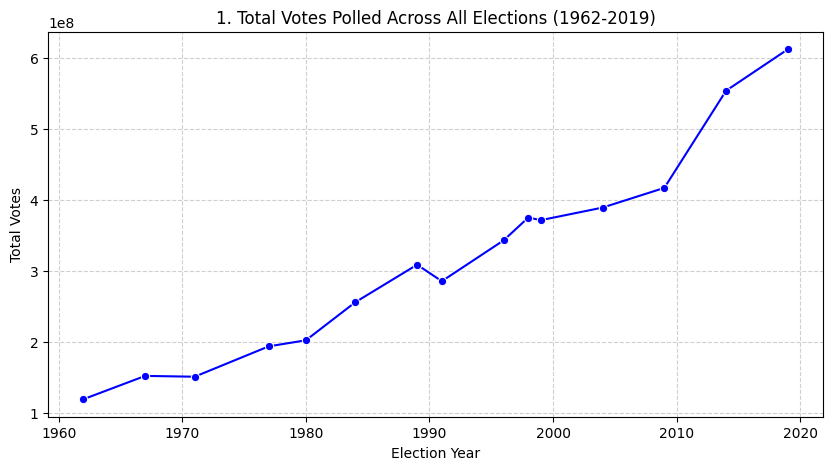

In [49]:
yearly_votes_df = (
    df_viz
    .groupBy("year")
    .agg(F.sum("votes").alias("Total_Votes"))
    .sort("year")
)
pd_yearly_votes = yearly_votes_df.toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='Total_Votes', data=pd_yearly_votes, marker='o', color='b')
plt.title('1. Total Votes Polled Across All Elections (1962-2019)')
plt.xlabel('Election Year')
plt.ylabel('Total Votes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2. Average Constituency Turnout by Year

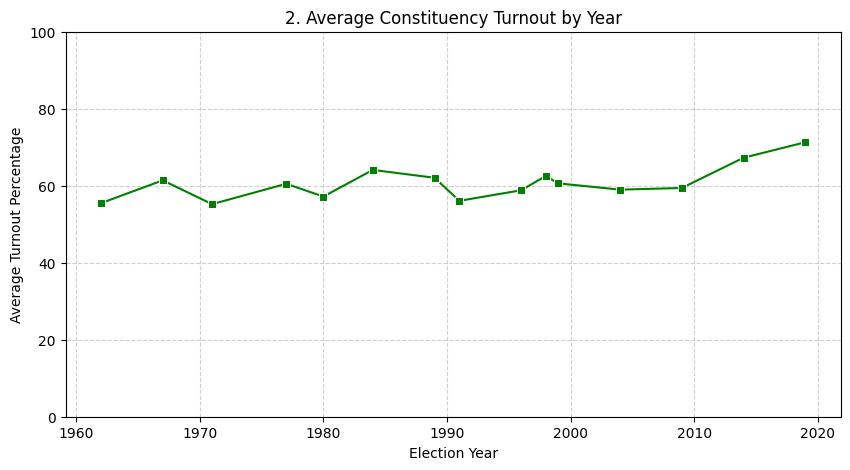

In [50]:
yearly_turnout_df = (
    df_viz
    .groupBy("year")
    .agg(F.avg("Turnout").alias("Avg_Turnout"))
    .sort("year")
)
pd_yearly_turnout = yearly_turnout_df.toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='Avg_Turnout', data=pd_yearly_turnout, marker='s', color='g')
plt.title('2. Average Constituency Turnout by Year')
plt.xlabel('Election Year')
plt.ylabel('Average Turnout Percentage')
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Visualization 3: Distribution of Candidate Votes (Histogram)

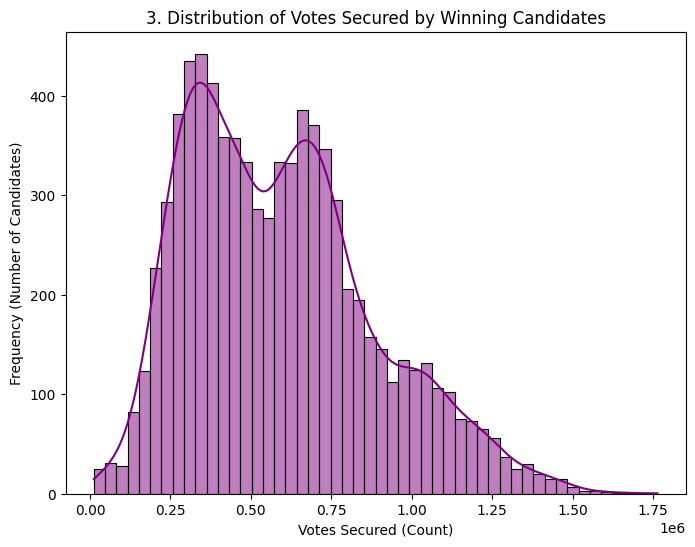

In [51]:
pd_votes = df_viz.select("votes").toPandas()

plt.figure(figsize=(8, 6))
sns.histplot(pd_votes['votes'], bins=50, kde=True, color='purple')
plt.title('3. Distribution of Votes Secured by Winning Candidates')
plt.xlabel('Votes Secured (Count)')
plt.ylabel('Frequency (Number of Candidates)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

# Visualization 4: Top 10 Parties by Total Votes (Categorical)

C:\Users\lohit\AppData\Local\Temp\ipykernel_2464\1686710293.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Votes', y='party', data=pd_top_parties_votes, palette='viridis')


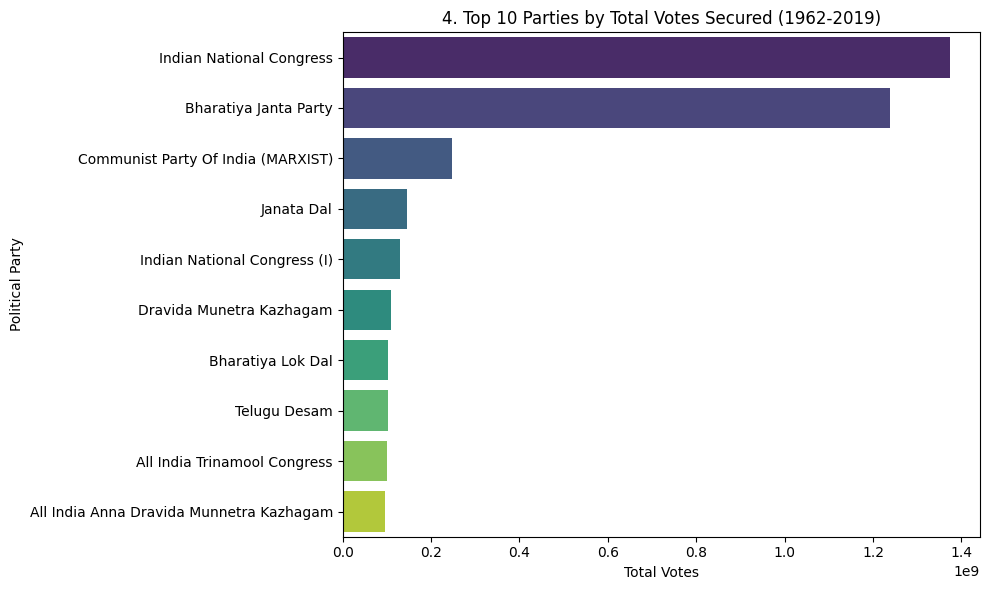

In [52]:
top_parties_votes_df = (
    df_viz
    .groupBy("party")
    .agg(F.sum("votes").alias("Total_Votes"))
    .sort(F.col("Total_Votes").desc())
    .limit(10)
)
pd_top_parties_votes = top_parties_votes_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Votes', y='party', data=pd_top_parties_votes, palette='viridis')
plt.title('4. Top 10 Parties by Total Votes Secured (1962-2019)')
plt.xlabel('Total Votes')
plt.ylabel('Political Party')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()
plt.show()

# Visualization 5: Top 10 States by Total Votes

C:\Users\lohit\AppData\Local\Temp\ipykernel_2464\1794442947.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Votes', y='state', data=pd_top_states_votes, palette='magma')


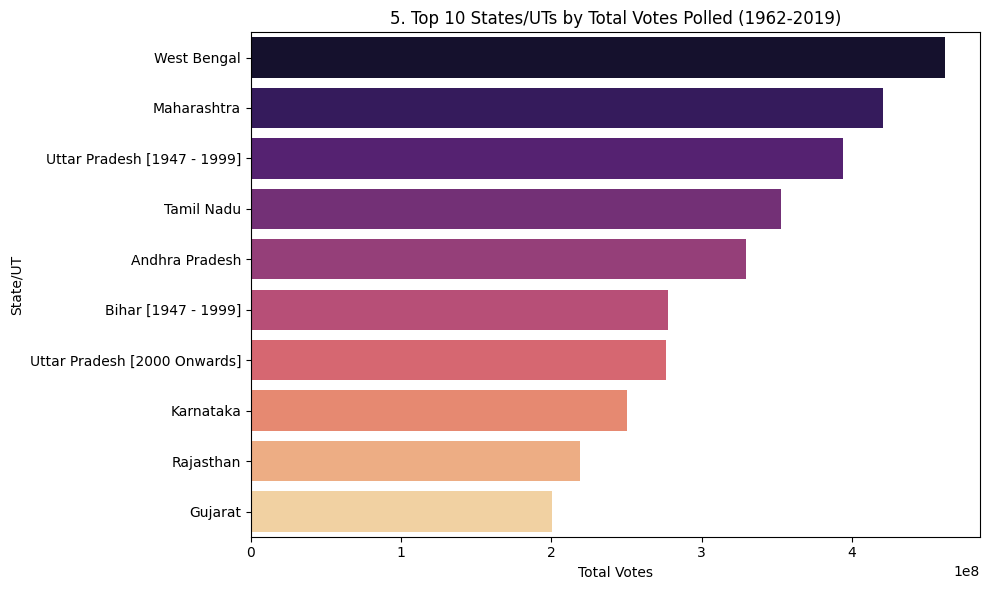

In [53]:
top_states_votes_df = (
    df_viz
    .groupBy("state")
    .agg(F.sum("votes").alias("Total_Votes"))
    .sort(F.col("Total_Votes").desc())
    .limit(10)
)
pd_top_states_votes = top_states_votes_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Votes', y='state', data=pd_top_states_votes, palette='magma')
plt.title('5. Top 10 States/UTs by Total Votes Polled (1962-2019)')
plt.xlabel('Total Votes')
plt.ylabel('State/UT')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()
plt.show()

# Visualization 6: Distribution of Turnout Percentage (KDE Plot)

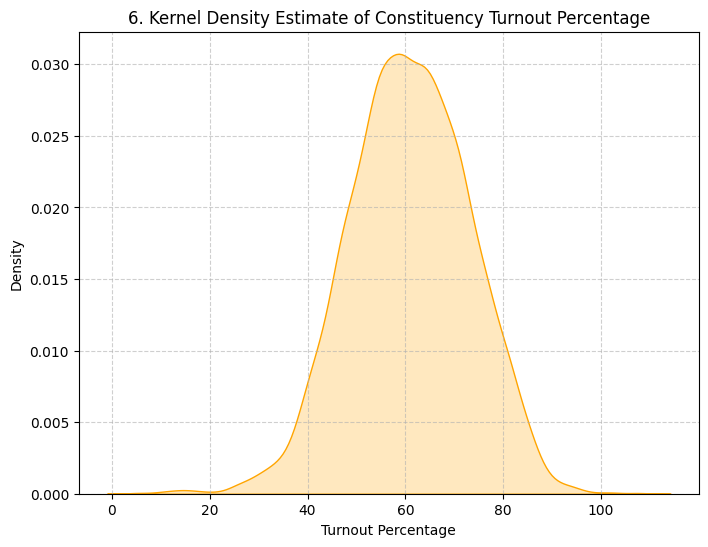

In [54]:
pd_turnout = df_viz.select("Turnout").toPandas()

plt.figure(figsize=(8, 6))
sns.kdeplot(pd_turnout['Turnout'], fill=True, color='orange')
plt.title('6. Kernel Density Estimate of Constituency Turnout Percentage')
plt.xlabel('Turnout Percentage')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Visualization 7: Distribution of Margin Percentage (Box Plot)

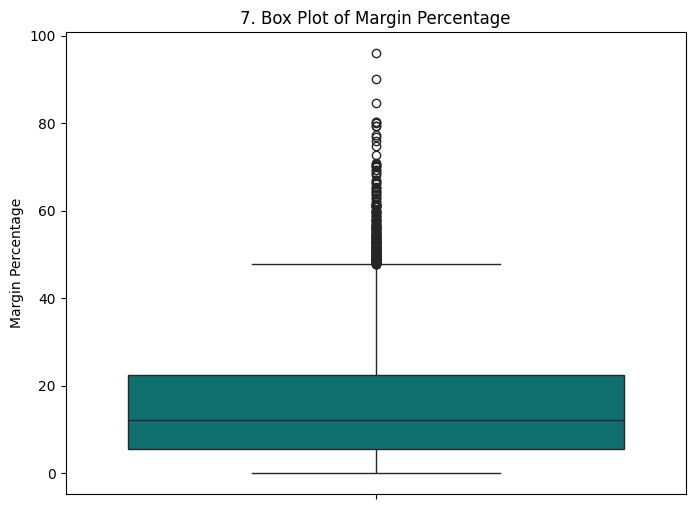

In [55]:
pd_margin_pct = df_viz.select("margin_percentage").toPandas()

plt.figure(figsize=(8, 6))
sns.boxplot(y=pd_margin_pct['margin_percentage'], color='teal')
plt.title('7. Box Plot of Margin Percentage')
plt.ylabel('Margin Percentage')
plt.show()

# Visualization 8: Top 10 Parties by Total Seats Won

C:\Users\lohit\AppData\Local\Temp\ipykernel_2464\3944087607.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Seats_Won', y='party', data=pd_top_parties_seats, palette='Reds_r')


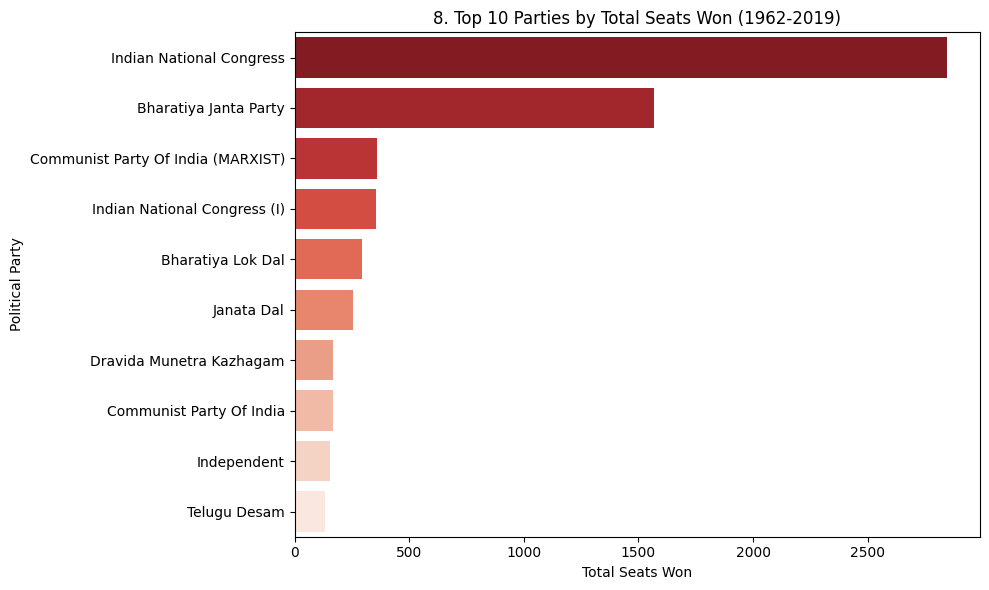

In [56]:
top_parties_seats_df = (
    df_viz
    .groupBy("party")
    .count()
    .withColumnRenamed("count", "Seats_Won")
    .sort(F.col("Seats_Won").desc())
    .limit(10)
)
pd_top_parties_seats = top_parties_seats_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Seats_Won', y='party', data=pd_top_parties_seats, palette='Reds_r')
plt.title('8. Top 10 Parties by Total Seats Won (1962-2019)')
plt.xlabel('Total Seats Won')
plt.ylabel('Political Party')
plt.tight_layout()
plt.show()

# Visualization 9: Average Margin Percentage by Party (Top 10)

C:\Users\lohit\AppData\Local\Temp\ipykernel_2464\2422002961.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg_Margin_Pct', y='party', data=pd_avg_margin_party, palette='Blues_d')


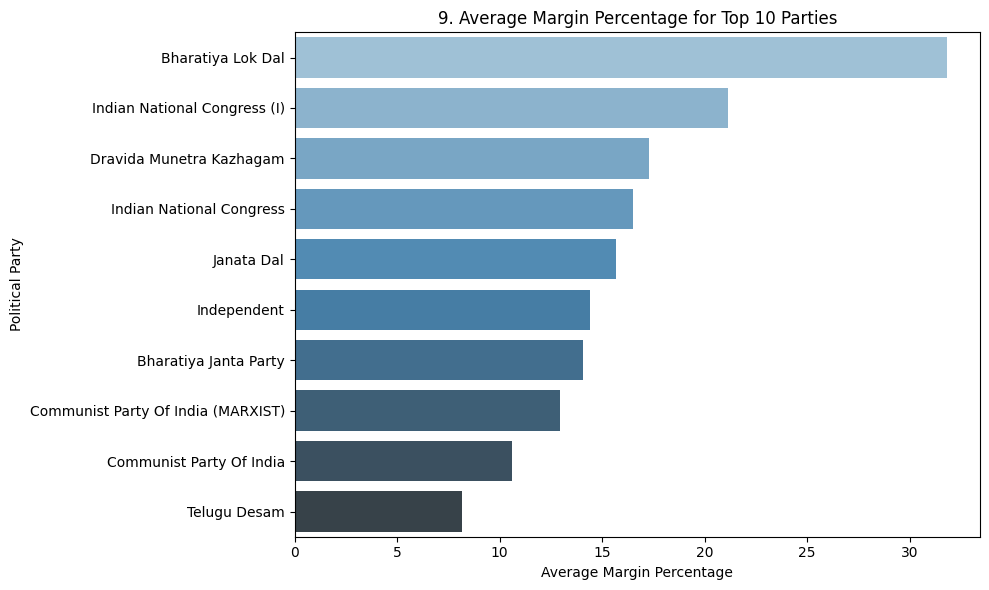

In [57]:
# Re-use the top 10 parties list from Vis 8 for context
top_10_parties = df_viz.groupBy("party").count().sort(F.col("count").desc()).limit(10).select("party").rdd.flatMap(lambda x: x).collect()

avg_margin_party_df = (
    df_viz
    .filter(F.col("party").isin(top_10_parties))
    .groupBy("party")
    .agg(F.avg("margin_percentage").alias("Avg_Margin_Pct"))
    .sort(F.col("Avg_Margin_Pct").desc())
)
pd_avg_margin_party = avg_margin_party_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Avg_Margin_Pct', y='party', data=pd_avg_margin_party, palette='Blues_d')
plt.title('9. Average Margin Percentage for Top 10 Parties')
plt.xlabel('Average Margin Percentage')
plt.ylabel('Political Party')
plt.tight_layout()
plt.show()

# Visualization 10: Electors vs. Votes (Relationship Scatter)

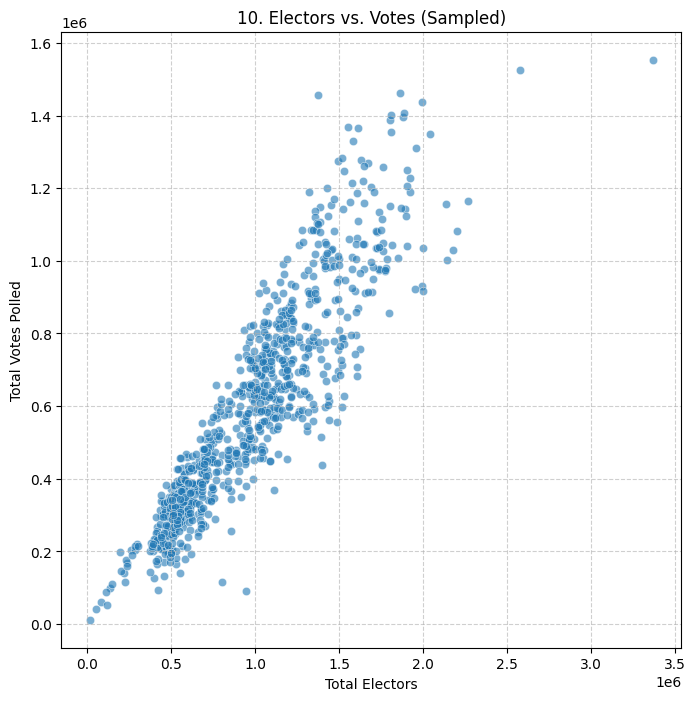

In [58]:
# Sample the data for faster plotting and clearer visualization
pd_sample = df_viz.sample(False, 0.1, seed=42).select("electors", "votes").toPandas()

plt.figure(figsize=(8, 8))
sns.scatterplot(x='electors', y='votes', data=pd_sample, alpha=0.6)
plt.title('10. Electors vs. Votes (Sampled)')
plt.xlabel('Total Electors')
plt.ylabel('Total Votes Polled')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Visualization 11: Votes vs. Turnout (Relationship Scatter)

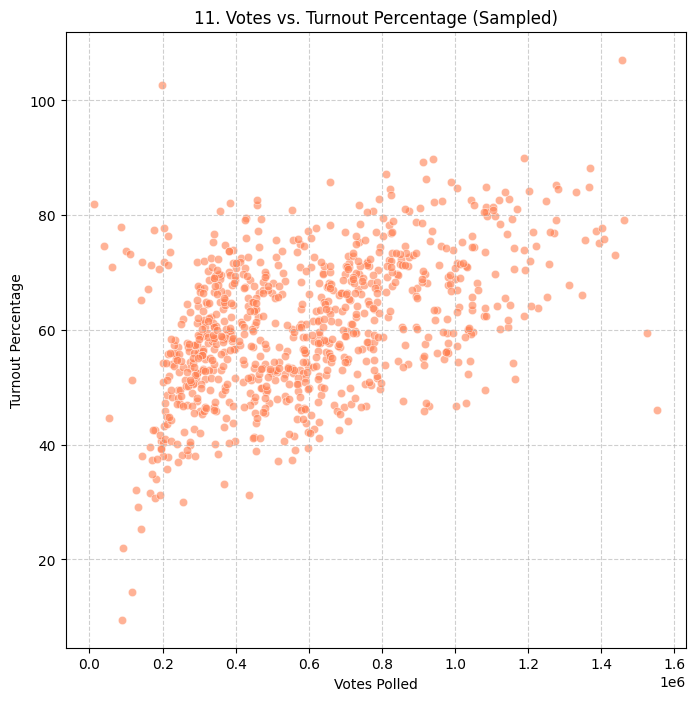

In [59]:
pd_sample_turnout = df_viz.sample(False, 0.1, seed=42).select("votes", "Turnout").toPandas()

plt.figure(figsize=(8, 8))
sns.scatterplot(x='votes', y='Turnout', data=pd_sample_turnout, alpha=0.6, color='coral')
plt.title('11. Votes vs. Turnout Percentage (Sampled)')
plt.xlabel('Votes Polled')
plt.ylabel('Turnout Percentage')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Visualization 12: Total Electors by Year (Time Series)

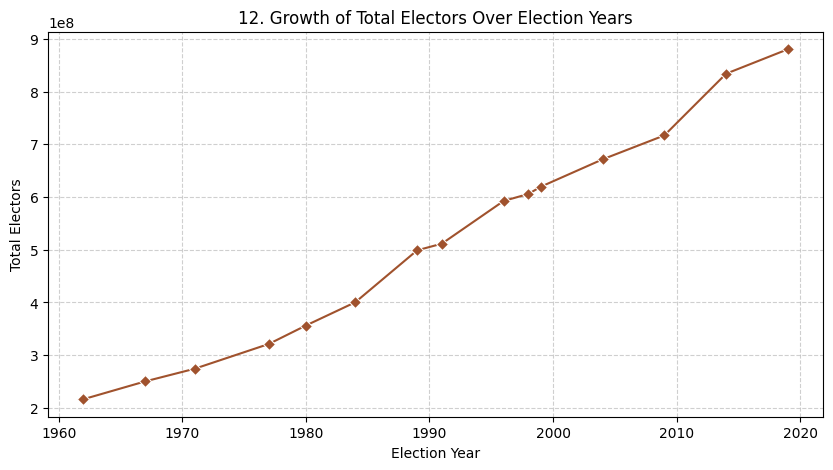

In [60]:
yearly_electors_df = (
    df_viz
    .groupBy("year")
    .agg(F.sum("electors").alias("Total_Electors"))
    .sort("year")
)
pd_yearly_electors = yearly_electors_df.toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='Total_Electors', data=pd_yearly_electors, marker='D', color='sienna')
plt.title('12. Growth of Total Electors Over Election Years')
plt.xlabel('Election Year')
plt.ylabel('Total Electors')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Visualization 13: Average Margin by Year (Time Series)

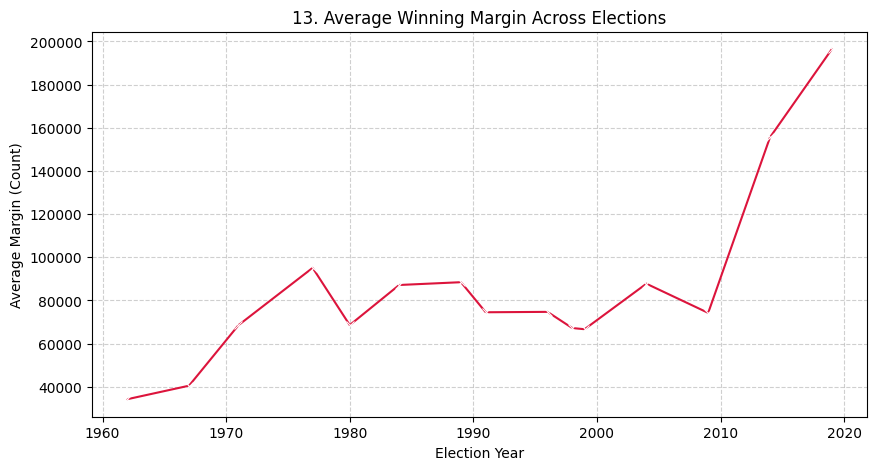

In [61]:
yearly_avg_margin_df = (
    df_viz
    .groupBy("year")
    .agg(F.avg("margin").alias("Avg_Margin"))
    .sort("year")
)
pd_yearly_avg_margin = yearly_avg_margin_df.toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='Avg_Margin', data=pd_yearly_avg_margin, marker='x', color='crimson')
plt.title('13. Average Winning Margin Across Elections')
plt.xlabel('Election Year')
plt.ylabel('Average Margin (Count)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Visualization 14: Share of Seats Won by Top 5 Parties (Pie Chart)

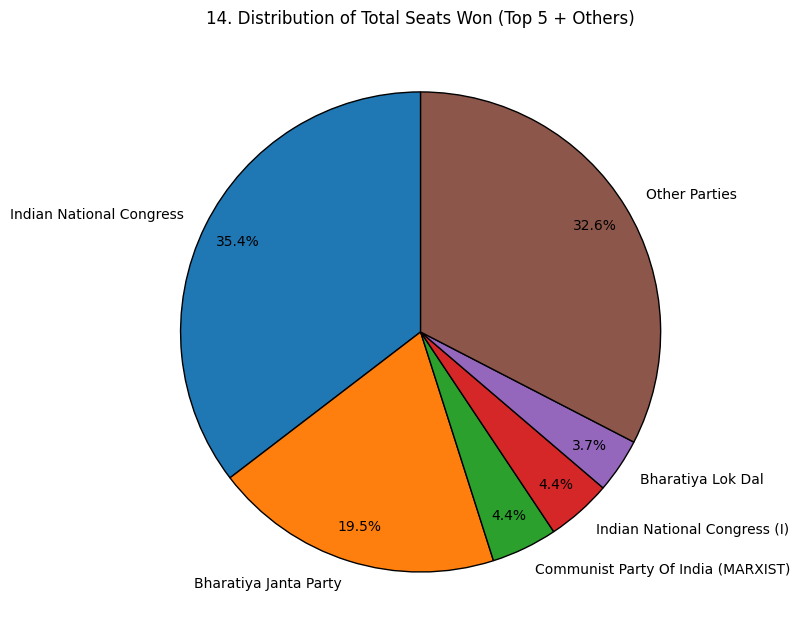

In [62]:
top_5_seats_df = (
    df_viz
    .groupBy("party")
    .count()
    .withColumnRenamed("count", "Seats_Won")
    .sort(F.col("Seats_Won").desc())
    .limit(5)
)
pd_top_5_seats = top_5_seats_df.toPandas()
total_seats = df_viz.count()
other_seats = total_seats - pd_top_5_seats['Seats_Won'].sum()
pd_top_5_seats.loc[len(pd_top_5_seats)] = ['Other Parties', other_seats]

plt.figure(figsize=(8, 8))
plt.pie(
    pd_top_5_seats['Seats_Won'],
    labels=pd_top_5_seats['party'],
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('14. Distribution of Total Seats Won (Top 5 + Others)')
plt.tight_layout()
plt.show()

# Visualization 15: Average Turnout by Constituency Type (Bar Plot

C:\Users\lohit\AppData\Local\Temp\ipykernel_2464\3394884669.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='type', y='Avg_Turnout', data=pd_avg_turnout_type, palette='Set1')


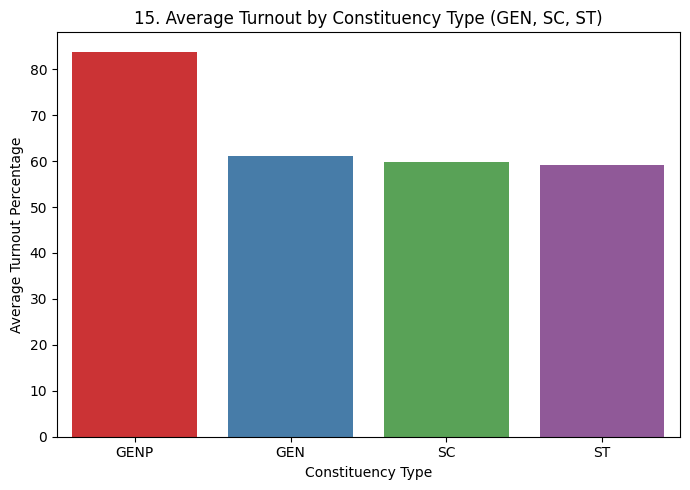

In [63]:
avg_turnout_type_df = (
    df_viz
    .groupBy("type")
    .agg(F.avg("Turnout").alias("Avg_Turnout"))
    .filter(F.col("type").isNotNull()) # Filter out null/unknown types
    .sort(F.col("Avg_Turnout").desc())
)
pd_avg_turnout_type = avg_turnout_type_df.toPandas()

plt.figure(figsize=(7, 5))
sns.barplot(x='type', y='Avg_Turnout', data=pd_avg_turnout_type, palette='Set1')
plt.title('15. Average Turnout by Constituency Type (GEN, SC, ST)')
plt.xlabel('Constituency Type')
plt.ylabel('Average Turnout Percentage')
plt.tight_layout()
plt.show()

# Visualization 16: Turnout Distribution for Latest Election Year (2019)

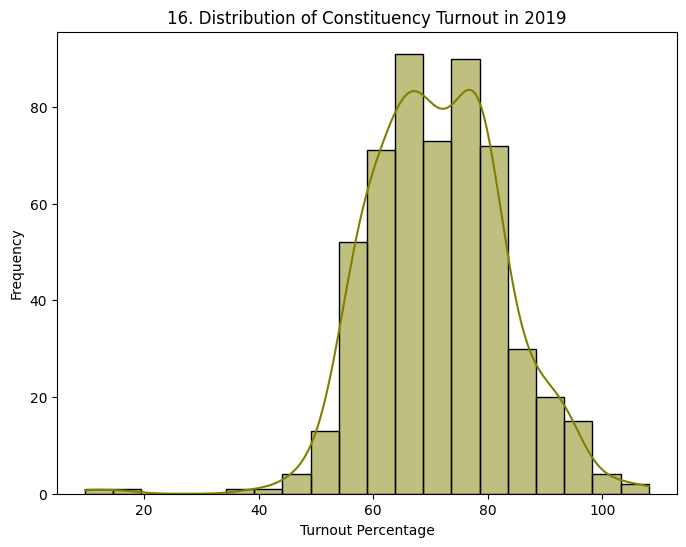

In [64]:
pd_turnout_2019 = df_viz.filter(F.col('year') == 2019).select("Turnout").toPandas()

plt.figure(figsize=(8, 6))
sns.histplot(pd_turnout_2019['Turnout'], bins=20, kde=True, color='olive')
plt.title('16. Distribution of Constituency Turnout in 2019')
plt.xlabel('Turnout Percentage')
plt.ylabel('Frequency')
plt.show()

# Visualization 17: Top 10 Parties by Margin in 2019

C:\Users\lohit\AppData\Local\Temp\ipykernel_2464\2630547823.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Margin', y='party', data=pd_top_margin_2019, palette='cool')


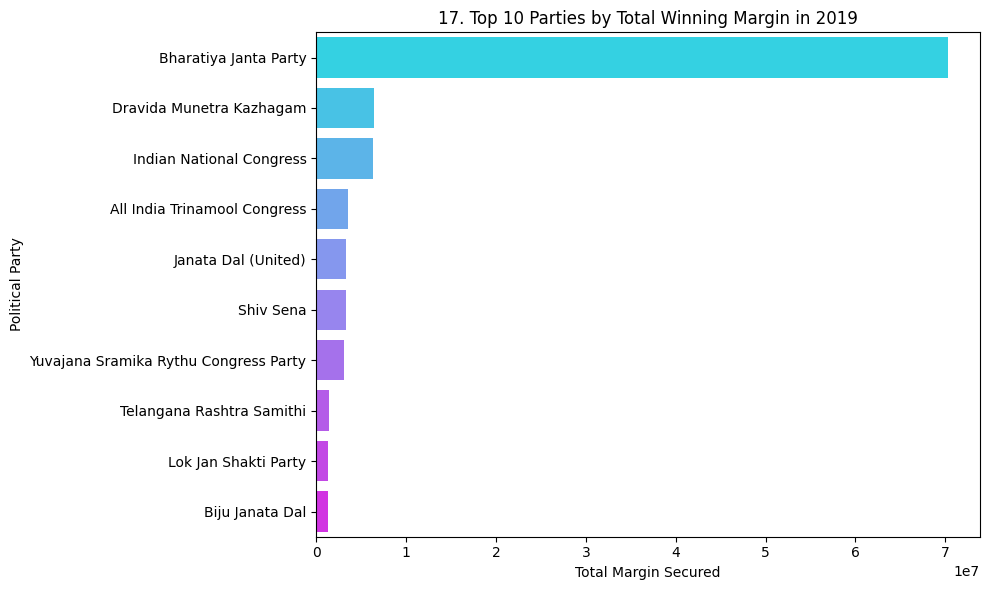

In [65]:
top_margin_2019_df = (
    df_viz
    .filter(F.col('year') == 2019)
    .groupBy("party")
    .agg(F.sum("margin").alias("Total_Margin"))
    .sort(F.col("Total_Margin").desc())
    .limit(10)
)
pd_top_margin_2019 = top_margin_2019_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Margin', y='party', data=pd_top_margin_2019, palette='cool')
plt.title('17. Top 10 Parties by Total Winning Margin in 2019')
plt.xlabel('Total Margin Secured')
plt.ylabel('Political Party')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()
plt.show()

# Visualization 18: Top 10 States by Total Electors in 2019

C:\Users\lohit\AppData\Local\Temp\ipykernel_2464\314900351.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Electors', y='state', data=pd_top_electors_2019, palette='plasma')


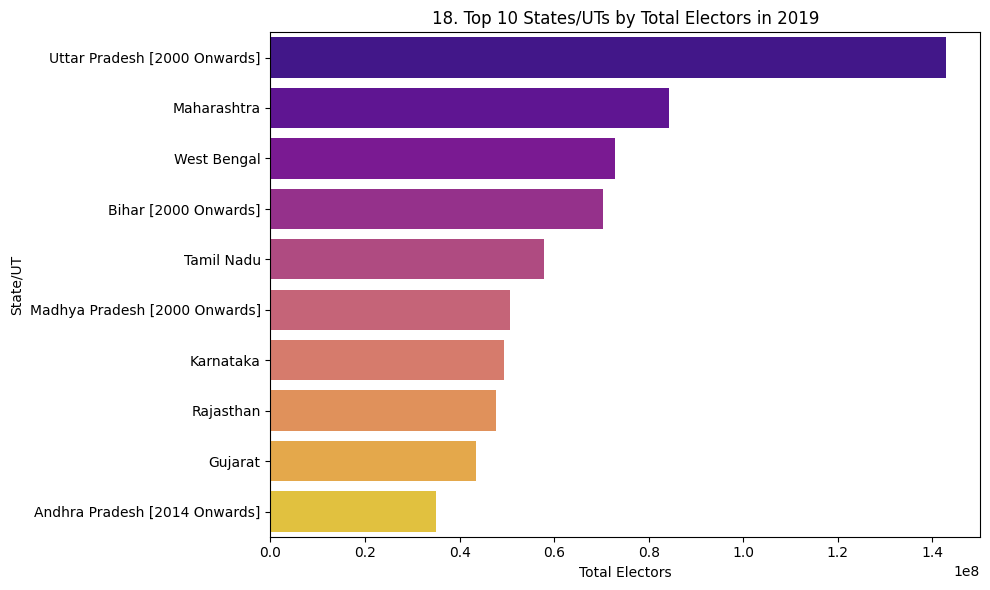

In [66]:
top_electors_2019_df = (
    df_viz
    .filter(F.col('year') == 2019)
    .groupBy("state")
    .agg(F.sum("electors").alias("Total_Electors"))
    .sort(F.col("Total_Electors").desc())
    .limit(10)
)
pd_top_electors_2019 = top_electors_2019_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Electors', y='state', data=pd_top_electors_2019, palette='plasma')
plt.title('18. Top 10 States/UTs by Total Electors in 2019')
plt.xlabel('Total Electors')
plt.ylabel('State/UT')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()
plt.show()

# Visualization 19: Turnout Distribution Comparison: 1962 vs 2019

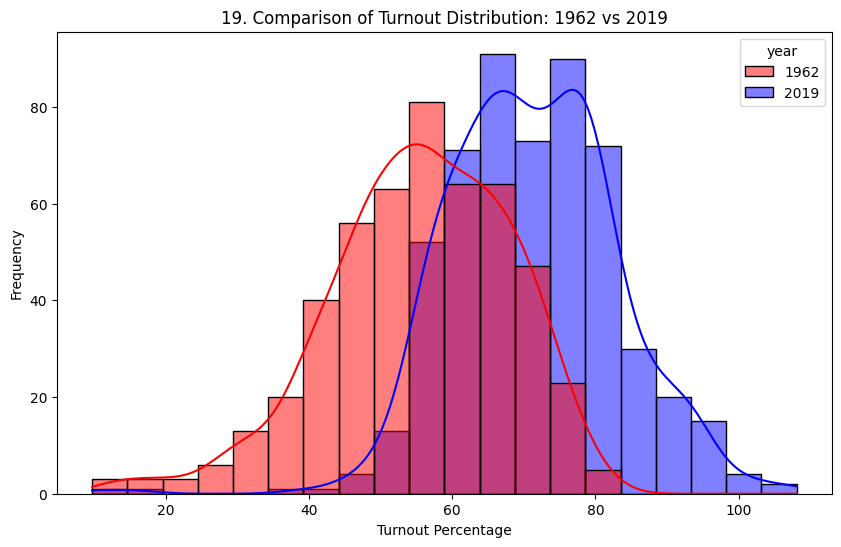

In [67]:
pd_turnout_compare = df_viz.filter(F.col('year').isin(1962, 2019)).select("Turnout", "year").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(
    data=pd_turnout_compare,
    x='Turnout',
    hue='year',
    bins=20,
    kde=True,
    palette=['red', 'blue'],
    alpha=0.5
)
plt.title('19. Comparison of Turnout Distribution: 1962 vs 2019')
plt.xlabel('Turnout Percentage')
plt.ylabel('Frequency')
plt.show()

# Visualization 20: Number of Close Contests (Margin < 1%) by Year

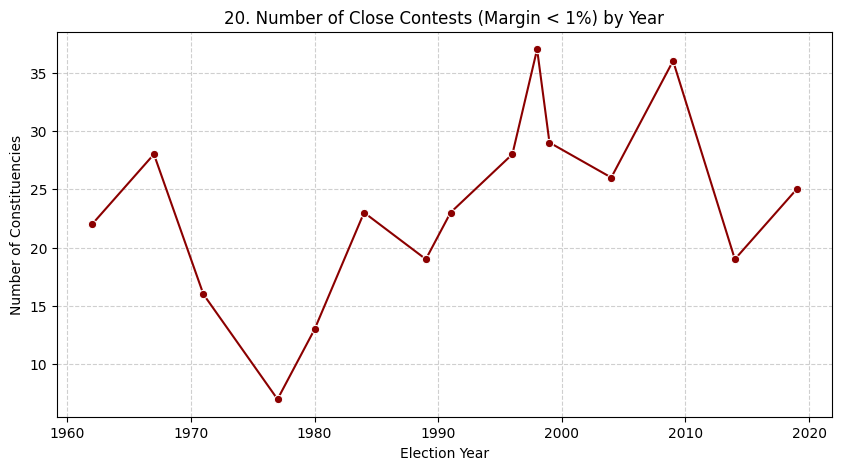

In [68]:
narrow_margin_df = (
    df_viz
    .filter(F.col("margin_percentage") < 1.0)
    .groupBy("year")
    .count()
    .withColumnRenamed("count", "Close_Contests")
    .sort("year")
)
pd_narrow_margin = narrow_margin_df.toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='Close_Contests', data=pd_narrow_margin, marker='o', color='darkred')
plt.title('20. Number of Close Contests (Margin < 1%) by Year')
plt.xlabel('Election Year')
plt.ylabel('Number of Constituencies')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [69]:
# Final Step (Run ONCE)

In [70]:
spark.stop()
print("SparkSession stopped.")

SparkSession stopped.


# Conclusion
The Loksabha_1962-2019 .csv dataset is an exceptionally valuable resource for longitudinal political science and big data analysis using PySpark.

The primary conclusion is that this dataset, once properly cleaned and typed, is perfectly structured to:

Track Historical Trends: Quantify the evolution of voter base, participation rates, and winning margins across specific decades.

Evaluate Party Performance: Provide a robust metric (votes vs. seats) to assess the political footprint of national and regional parties over time.

Identify Electoral Anomalies: Pinpoint regions or years characterized by either overwhelming mandates or extremely close, high-stakes contests.

In essence, the dataset serves as a statistical backbone for understanding the changing dynamics and historical narrative of Indian democracy from its early years up to the present day.